In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.ma as ma

import healpy as hp
from lsst.sims.utils import _hpid2RaDec, _approx_RaDec2AltAz
from lsst.sims.utils import Site

from lsst.sims.utils import TimeHandler
from astropy.time import Time
import lsst.sims.cloudModel as cm

In [2]:
# Set up a CloudModelConfig .. this could then be modified before passing to CloudModel. 
conf = cm.CloudModelConfig()

In [4]:
for k, v in conf.iteritems():
    print(k, v)

efd_columns ['cloud']
efd_delta_time 0.0


In [5]:
# Set up and configure the CloudModel. (note that configure with no kwarg will just use defaults, as above)
cloudModel = cm.CloudModel(conf)  

In [6]:
# Dump the config properties and version info.
cloudModel.status()

OrderedDict([('CloudModel_version', 'unknown'),
             ('CloudModel_sha', 'f3ce61a0aafdc34e611c1fc08968029070731495 *'),
             ('efd_columns', ['cloud']),
             ('efd_delta_time', 0.0),
             ('map_columns', ['altitude', 'azimuth'])])

In [7]:
# Find the values the model wants from the EFD. 
cols, deltaT = cloudModel.efd_requirements
print(cols, deltaT)
# Find the columns the model wants in its input map (over which to calculate the seeing values)
print(cloudModel.map_requirements)

['cloud'] 0.0
['altitude', 'azimuth']


In [8]:
# Set up to get seeingData from db..  (this is where EFD would step in, in future)
t = TimeHandler(initial_date='2022-10-01')
t2 = Time('2002-01-01', scale='utc', format='isot')

cloudData = cm.CloudData(t)
cloudData.read_data()

In [9]:
# Take a quick peek at the FWHM_500 values throughout the lifetime of the survey. 
# (remember that the current DB repeats after a few years)
t_end = 3650 * 24 * 60 * 60  # seconds
t_step = 300
times = np.arange(0, t_end + t_step/2, t_step)
cloud = np.zeros(len(times), float)
for i, t_now in enumerate(times):
    cloud[i] = cloudData(t_now)

Text(0, 0.5, 'CLOUD')

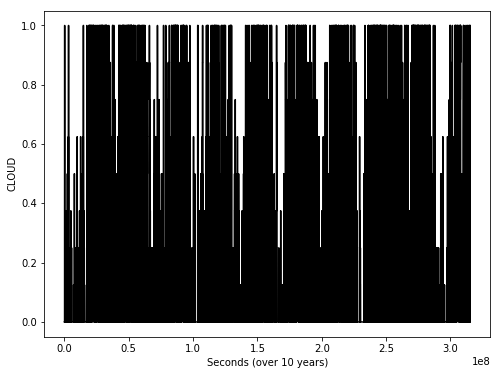

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(times, cloud, 'k-')
plt.xlabel('Seconds (over 10 years)')
plt.ylabel('CLOUD')

In [13]:
# Set up grid around sky .. (places we'd be likely to calculate the FWHM_eff in the FBS)
lsst_site = Site('LSST')
nside = 32
hpid = np.arange(hp.nside2npix(nside))
ra, dec = _hpid2RaDec(nside, hpid)
alt, az = _approx_RaDec2AltAz(ra, dec, lsst_site.latitude_rad, lsst_site.longitude_rad, t2.mjd)

# If we set the mask here - it propagates. 
mask = np.where(alt < np.radians(20), True, False)
visible = np.where(alt > np.radians(20))

airmass = np.zeros(len(alt))
airmass[visible] = 1./np.cos(np.pi/2. - alt[visible])

In [21]:
cloud = cloudData(t_now)
print(cloud)

0.0


In [22]:
# Put input telemetry and target map into dictionaries:
mapDict = {'altitude': alt, 'azimuth': az}
mapDictMask = {'altitude': alt[visible], 'azimuth': az[visible]}
efdDict = {'cloud': cloud}

In [23]:
%%timeit
# Check time to calculate seeing. No mask. 
cloud_sky = cloudModel(efdDict, mapDict)

10.6 µs ± 59.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [24]:
%%timeit
# Check time to calculate seeing. WITH mask.
cloud_sky = np.zeros(len(alt), float)
#print(fwhm_eff[:, visible[0]].shape)
cloud_sky[visible] = cloudModel(efdDict, mapDictMask)

14.5 µs ± 161 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [27]:
# And then what about time, if you pre-allocate arrays?
cloud_sky = np.zeros(len(alt), float)

In [28]:
%%timeit
cloud_sky[visible] = cloudModel(efdDict, mapDictMask)

10.6 µs ± 211 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [38]:
# Loop over a bunch of times and calculate values.. (maybe what you'd do in the driver)
t_end = 10 * 60 * 60  # seconds
t_step = 30 # seconds
times = np.arange(0, t_end + t_step/2, t_step)
cloud_sky = np.ones(len(alt), float)
for i, t_now in enumerate(times):
    cloud_sky[visible] = cloudModel({'cloud': cloudData(t_now)}, mapDictMask)

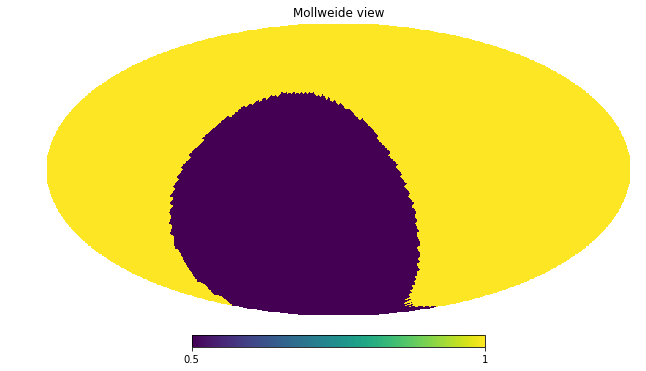

In [39]:
cloud_sky = np.ones(len(alt), float)
for i, t_now in enumerate(times):
    cloud_sky[visible] = cloudModel({'cloud':0.5}, mapDictMask)
hp.mollview(cloud_sky)